<a href="https://colab.research.google.com/github/ErSongHeng/DSA4212_Assignment1/blob/main/DSA_assignment_dropout_flax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSA4212 Assignment 1: Group 2 Final Model

In [ ]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time

In [ ]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [ ]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-2393cbd2-336d-ebae-ae8c-9fa00d05c2a6)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
12G


# Connect to Google Drive & Load data

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%pwd

'/content/drive/My Drive/DSA4212/dataset/assignment_1'

In [ ]:
# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/dataset/DSA4212/assignment_1/

/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train_all = np.load("assignment_1_train.npz")
data_test = np.load("assignment_1_test.npz")

X_train_all = data_train_all["img"].astype(np.float32) / 255.   # set pixel intensities to [0,1]
X_test = data_test["img"].astype(np.float32) / 255.
Y_train_all = data_train_all["label"].astype(int)
Y_test = data_test["label"].astype(int)

_,H,W,C = X_train_all.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [ ]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train_all))
np.random.shuffle(indices_shuffled)
X_train_all = X_train_all[indices_shuffled]
Y_train_all = Y_train_all[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_test))
np.random.shuffle(indices_shuffled)
X_test = X_test[indices_shuffled]
Y_test = Y_test[indices_shuffled]

In [ ]:
sz_train = X_train_all.size * X_train_all.itemsize / 2.**30
sz_val = X_test.size * X_test.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


# Split Train / Validation / Test

The test set can only be used for the final evaluation of the model: one cannot use the test set when tuning the models. Consequently, we are going to split `X_train_all` into a train-set and a validation-set.

In [ ]:
len_train_all = len(X_train_all)
len_train = int(0.8 * len_train_all)
len_val = len_train_all - len_train
len_tets = len(X_test)

X_train = X_train_all[:len_train]
Y_train = Y_train_all[:len_train]

X_val = X_train_all[len_train:]
Y_val = Y_train_all[len_train:]


# Sanity checks
Let us make sure that the data is all ok

Text(0.5, 1.0, 'Pixel Intensity')

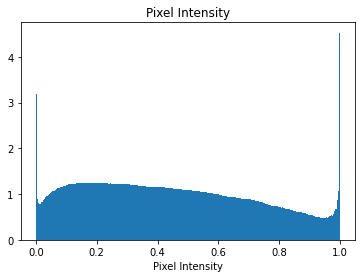

In [ ]:
# histogram of pixel intensities
_ = plt.hist(X_train.ravel(), bins=256, density=True)
plt.xlabel("Pixel Intensity")
plt.title("Pixel Intensity")

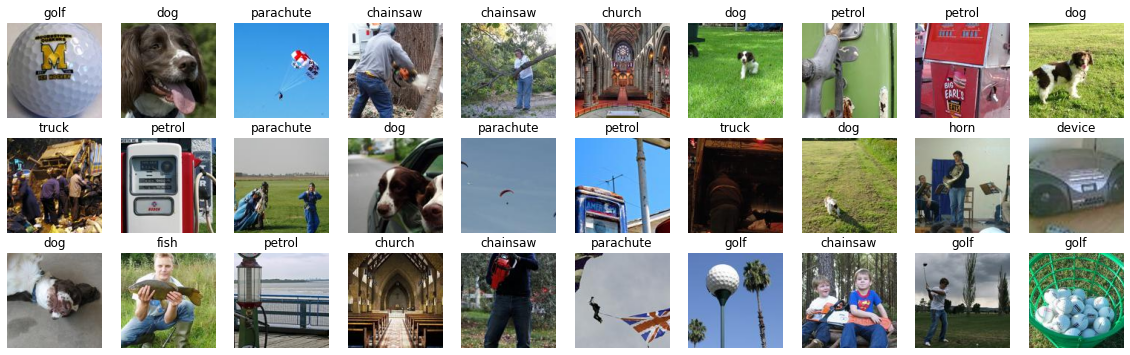

In [ ]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

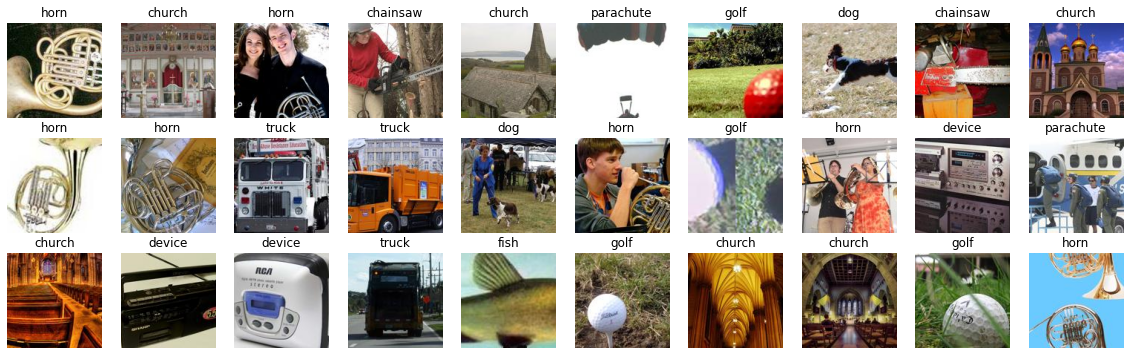

In [ ]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [ ]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn
from flax.training import train_state

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
import jax
import jax.numpy as jnp
import os
from jax import random
from jax import make_jaxpr
from jax.config import config
from jax import value_and_grad
from jax import grad, vmap, pmap, jit
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [ ]:
# setting seed
np.random.seed(1234)
%config IPCompleter.use_jedi = False

# Creating CNN

In [ ]:
# A. Model defintion

class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)


# Inherit the Module class for building the neural network
class CNN(nn.Module):
  n_class: int  
  n_filters: Sequence[int] 

  @nn.compact
  def __call__(self, x,training=None):
    #conv layers+Normalization+dropout+maxpool layers
    for i, feat_dim in enumerate(self.n_filters):
      x = LayerNorm()(x)
      x = nn.Conv(features=feat_dim, kernel_size=(3, 3), strides=2,padding="SAME",name=f'layers_{i}_1')(x)
      x = nn.max_pool(x, (2,2))
      x=nn.relu(x)

    # pooling -- average across the dimension (1,2)
    x =  x.mean(axis=(1,2)) 

    # last Dense layer
    # x = nn.Dense(128)(x)
    x=nn.Dropout(rate=0.1)(x, deterministic=not training)
        
    x = nn.Dense(10)(x)
    #return softmax activations 
    probas = nn.softmax(x)
    return probas 
#call model instance
model=CNN(n_filters=[32,64, 128],n_class=10)

In [ ]:
# B. Loss function we want to use for the optimization
@jax.jit
def loss(params, x, y,train=False):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = model.apply({'params': params}, x,training=train)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# loss function for training set
def loss_train_fn(params, x, y,dropout_key,train=True):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = model.apply({'params': params}, x,training=train,rngs={'dropout': dropout_key})
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)


# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )
loss_train_value_and_grad=jax.jit( jax.value_and_grad(loss_train_fn) )


In [ ]:
# C. Evaluation metric

@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = model.apply({'params': params}, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy_fn(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

In [ ]:
# D. Train step. We will `jit` transform it to compile it. We will get a 
# good speedup on the subseuqent runs
@jax.jit
def train_step(state, inputs,labels,dropout_key): #batch image just means x
    """Defines the single training step.
    
    Args:
        state: Current `TrainState` of the model
        batch_data: Tuple containingm a batch of images and their corresponding labels
    Returns:
        loss: Mean loss for the current batch
        accuracy: Mean accuracy for the current batch
        state: Updated state of the model
    """



    # 1. get the dropout key
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)



    # 2. Calculate the loss and get the gradients
    loss, grads =loss_train_value_and_grad(state.params,inputs,labels,dropout_train_key )

    # 3. Calculate the accuracy for the cuurent batch
    accuracy = accuracy_fn(state.params,inputs,labels)
    
    # 4. Update the state (parameters values) of the model
    state = state.apply_gradients(grads=grads)
    
    # 5. Return loss, accuracy and the updated state
    return loss, accuracy, state

In [ ]:
# E. Test/Evaluation step. We will `jit` transform it to compile it as well.
@jax.jit
def test_step(state, inputs,labels):
    """Defines the single test/evaluation step.
    
    Args:
        state: Current `TrainState` of the model
        batch_data: Tuple containingm a batch of images and their corresponding labels
    Returns:
        loss: Mean loss for the current batch
        accuracy: Mean accuracy for the current batch
    """



    
    # 2. Calculate the loss
    loss,grads=loss_value_and_grad(state.params,inputs,labels)
    
    # 3. Calculate the accuracy
    accuracy = accuracy_fn(state.params,inputs,labels)
    
    # 4. Return loss and accuracy values
    return loss, accuracy
    

In [ ]:
class TrainState(train_state.TrainState):
  key: jax.random.KeyArray
# F. Initial train state including parameters initialization
def create_train_state(key, lr=0.005): #key parameter should be a random.PRNGkey object
    """Creates initial `TrainState for our classifier.
    
    Args:
        key: PRNG key to initialize the model parameters
        lr: Learning rate for the optimizer
    
    """
    #1. call model instance but it is called outside 
    
    # 2. Initialize the parameters of the model by passing a random batch of image to init 
    key, key_,dropout_key= jax.random.split(key,num=3)

    batch_size = 32
    batch_of_images = X_train[:batch_size,:,:,:]
    params = model.init(key_, batch_of_images,training=False)['params']
    
    # 3. Define the optimizer with the desired learning rate
    optimizer = optax.adam(learning_rate=lr,eps=0.001)
    
    #print number of parameters
    param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
    print(f"Number of Neural Parameters: {param_count//1000}k")
    
    # 4. Create and return initial state from the above information. The `Module.apply` applies a 
    # module method to variables and returns output and modified variables.
    state=TrainState.create(apply_fn=model.apply,params=params,key=dropout_key,tx=optimizer)
    #train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
    return state,dropout_key

In [ ]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)

#intialise training state
state_init,dropout_key=create_train_state(key)


#logits= state_init.apply_fn({'params': state_init.params},x=X_val,training=True,rngs={'dropout': dropout_key})
#loss=optax.softmax_cross_entropy_with_integer_labels(logits=logits,labels=Y_val)
#loss

Number of Neural Parameters: 94k


In [ ]:
# put data to GPU
X_train = jax.device_put(X_train)
X_val = jax.device_put(X_val)


In [ ]:

batch_size = 512
niter=1000

#let us randomize the weights again to start from scratch
state=copy.deepcopy(state_init)

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

time_start = time.time()
#start of training algo 
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train,acc_train,state=train_step(state, X_batch, Y_batch,dropout_key) # "update mechanism" and optimser is alrdy updated in new state object
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = batch_size
    loss_val,acc_val=test_step(state, X_val[:N], Y_val[:N])

    acc_val = 100*acc_val
    acc_train = 100*acc_train
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)
    
    # also compute validation loss


    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train)



  0%|          | 0/1000 [00:00<?, ?it/s]

Time:3.7sec 	 Epoch:0.1 	 Loss [2.59 / 2.32] 	 Accuracy Train/Valid: [10.35% / 12.50%]
Time:9.5sec 	 Epoch:3.5 	 Loss [1.49 / 1.35] 	 Accuracy Train/Valid: [56.84% / 60.94%]
Time:14.4sec 	 Epoch:7.0 	 Loss [1.29 / 1.15] 	 Accuracy Train/Valid: [63.87% / 62.50%]
Time:19.5sec 	 Epoch:10.4 	 Loss [1.11 / 1.03] 	 Accuracy Train/Valid: [72.66% / 67.77%]
Time:24.5sec 	 Epoch:13.8 	 Loss [1.08 / 0.92] 	 Accuracy Train/Valid: [74.22% / 72.07%]
Time:29.7sec 	 Epoch:17.3 	 Loss [0.98 / 0.88] 	 Accuracy Train/Valid: [74.80% / 72.27%]
Time:34.9sec 	 Epoch:20.7 	 Loss [0.99 / 0.89] 	 Accuracy Train/Valid: [75.00% / 72.27%]
Time:40.0sec 	 Epoch:24.2 	 Loss [0.90 / 0.83] 	 Accuracy Train/Valid: [77.54% / 73.24%]
Time:45.1sec 	 Epoch:27.6 	 Loss [0.84 / 0.79] 	 Accuracy Train/Valid: [80.27% / 75.98%]
Time:50.1sec 	 Epoch:31.1 	 Loss [0.85 / 0.82] 	 Accuracy Train/Valid: [80.47% / 73.63%]
Time:54.9sec 	 Epoch:34.5 	 Loss [0.76 / 0.80] 	 Accuracy Train/Valid: [82.23% / 75.59%]
Time:59.8sec 	 Epoch:37.9 

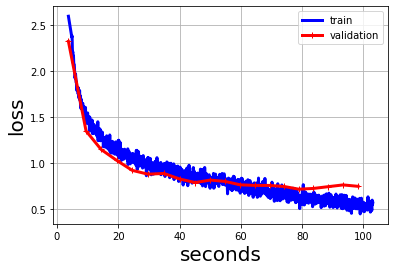

In [ ]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


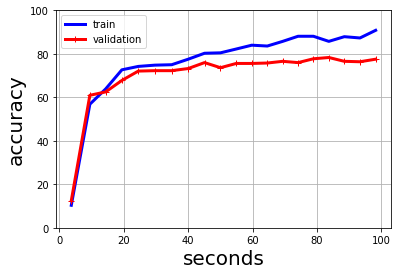

In [ ]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

# Test Accuracy
Note we have at no point used the test-set previously.

In [ ]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(state.params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(state.params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Test Accuracy: 77.2%
